In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import os
from time import time

In [30]:
# gg is the number of days the model tests on then continues to the next 90 and so on
gg = 90


In [31]:
def main():
    time_frames = [60, 90, 180]
    current_time = time()
# saves the plots into seperate files each run
    if not os.path.exists(f'photos/graphs_{current_time}'):
        if not os.path.exists('photos'):
            os.mkdir('photos')
        os.makedirs(f'photos/graphs_{current_time}')

    for tf in time_frames:
        run(str(tf)+"T", current_time)


In [32]:
def run(time_frame, current_time):

    df = pd.read_csv("./Bitstamp_BTCUSD_2021_minute_-_Copy.csv")

    df = preProcess(df, time_frame)

    sc, trainX, trainY = dataProcessing(df)

    # this function splits the data
    # you can also choose the amount of data to be used for training and the amount to be used for testing
    X_train, X_test, y_train, y_test = train_test_split(
        trainX, trainY, test_size=0.80, shuffle=False)

    model = createModel()

    model, history = trainModel(model, X_train, y_train)

    y_pred, score1, score2 = testModel(model, X_test, y_test)

    plot(sc, history, y_test, y_pred, time_frame, current_time)
    print("RMS= ", score1)
    print("R2 Score= ", score2)


In [33]:
def preProcess(df, t):
    # Converts Unix time to normal readble format
    df["date"] = pd.to_datetime(df["unix"], unit='s')
    df.set_index("date", inplace=True)
# resampels the data ito the time frames wanted
    df2 = df.resample(t).agg({
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last"
    })
    # only returs the open, as this is the only thing used
    return df2[["open"]]


In [34]:
def showPlot(df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=df.index, y="open", data=df).set_title(
        "Price of bitcoin test")

    # the under lines makes the graph looks smoother

    df.resample('10D').mean().plot(figsize=(12, 6))
    plt.figtext(.5, 0.9, "Down-sampled to 10-day periods",
                fontsize=20, ha='center')

    pass


In [35]:
def dataProcessing(df2):
    # this function is for scaling the data using StandardScaler
    n_past = gg
    n_future = 1
    trainX = []
    trainY = []
    scaler = StandardScaler()
    scaler = scaler.fit(df2)

    df_for_training_scaled = scaler.transform(df2)

    for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
        trainX.append(df_for_training_scaled[i - n_past:i, 0:df2.shape[1]])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    return scaler, trainX, trainY


In [36]:
def dataProcessing1(df):
    # This function also scales the data but using MinMaxScaler
    data = df.iloc[:, 0]
    sc = MinMaxScaler()

    hist = []
    target = []
    length = gg
    for i in range(len(data)-length):
        x = data[i:i+length]
        y = data[i+length]

        hist.append(x)
        target.append(y)

    hist = np.array(hist)

    target = np.array(target)
    target = target.reshape(-1, 1)

    hist_scaled = sc.fit_transform(hist)
    target_scaled = sc.fit_transform(target)

    hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))

    return sc, hist_scaled, target_scaled


In [37]:
def createModel():
    # This function is to create the model
    model = tf.keras.Sequential()
    model.add(layers.LSTM(units=32, return_sequences=True,
                          input_shape=(gg, 1), dropout=0.2))

    model.add(layers.LSTM(units=32, dropout=0.2))
    model.add(layers.Dense(units=1))
    model.summary()

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [38]:
def trainModel(model, X_train, y_train):
    # this function is to start to train the model
    # you can change the hyperperameters of the model here
    # change the batch size and the epochs
    history = model.fit(X_train, y_train, epochs=10, batch_size=32)
    return model, history


In [39]:
def testModel(model, X_test, y_test):
    # This function is for testing the model after it has been trained
    y_pred = model.predict(X_test)
# score1 one is to calculate the RMS
    score1 = mean_squared_error(y_test, y_pred, squared=False)
    # score2 is to calculate the R^2 score
    score2 = r2_score(y_test, y_pred)
    # scores = [score1, score2]
    return y_pred, score1, score2


In [40]:
def plot(sc, history, y_test, y_pred, ts, current_time):
    # This function is to polt the results after the training and testing
    loss = history.history['loss']
    epoch_count = range(1, len(loss) + 1)

    # polt the epoch ad the training loss
    plt.figure(figsize=(12, 8))
    plt.plot(epoch_count, loss, 'r--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')

    plt.ylabel('Loss')
    # saves the plot
    plt.savefig(f"photos/graphs_{current_time}/{ts}_Training_Loss.png")

    plt.show()

    plt.figure(figsize=(12, 8))
    y_pred = sc.inverse_transform(y_pred)
    y_test = sc.inverse_transform(y_test)
    # Polt the real data vs the models prediction
    plt.plot(y_test, color='blue', label='Real')
    plt.plot(y_pred, color='red', label='Prediction')
    plt.title('Bitcoin Price Prediction')

    plt.legend()
# saves the plot
    plt.savefig(
        f"photos/graphs_{current_time}/{ts}_Bitcoin_Price_Prediction.png")
    plt.show()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 90, 32)            4352      
                                                                 
 lstm_13 (LSTM)              (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5/5 [==============================] - 5s 54ms/step - loss: 0.1850
Epoch 2/10
5/5 [==============================] - 0s 60ms/step - loss: 0.1190
Epoch 3/10
5/5 [==============================] - 0s 56ms/step - loss: 0.0898
Epoch 4/10
5/5 [==============================] - 0s 56ms/step - loss: 0.0861
Ep

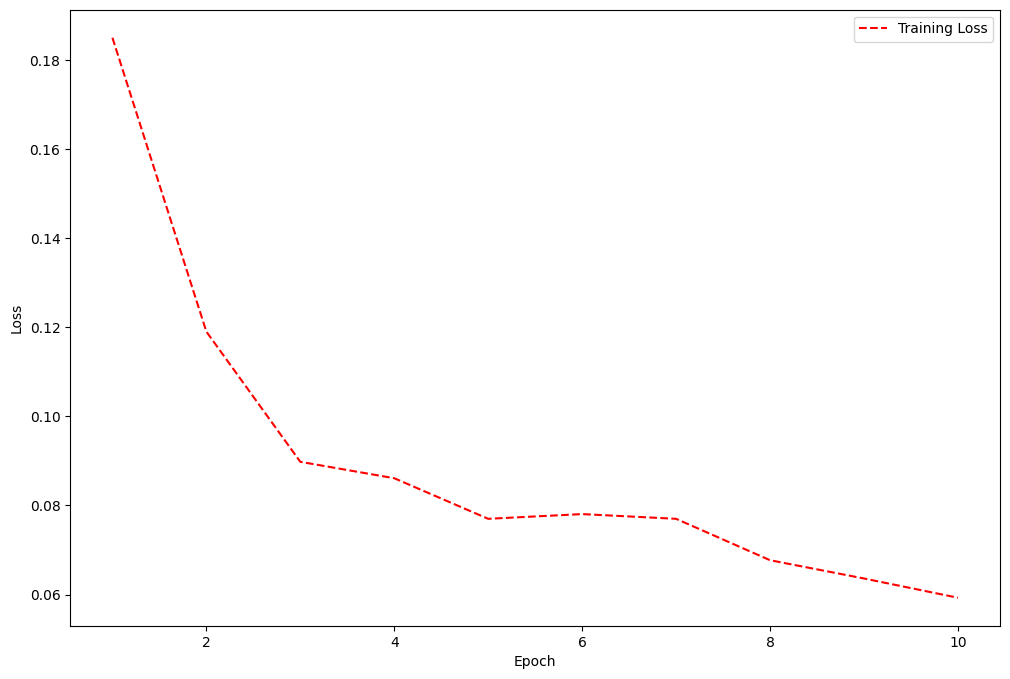

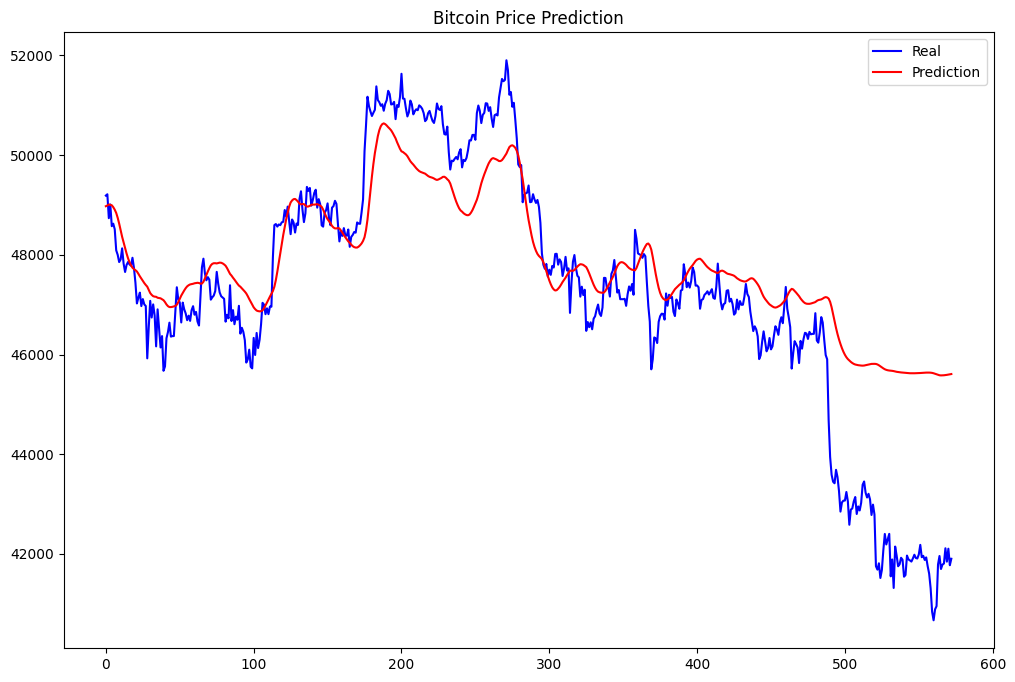

RMS=  0.6423387698561767
R2 Score=  0.6426794611514661
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 90, 32)            4352      
                                                                 
 lstm_15 (LSTM)              (None, 32)                8320      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 3s 55ms/step - loss: 0.1849
Epoch 2/10
3/3 [==============================] - 0s 63ms/step - loss: 0.1592
Epoch 3/10
3/3 [==============================] - 0s 59ms/step - loss: 0.1456
Epoch 4/10
3/3 [=========

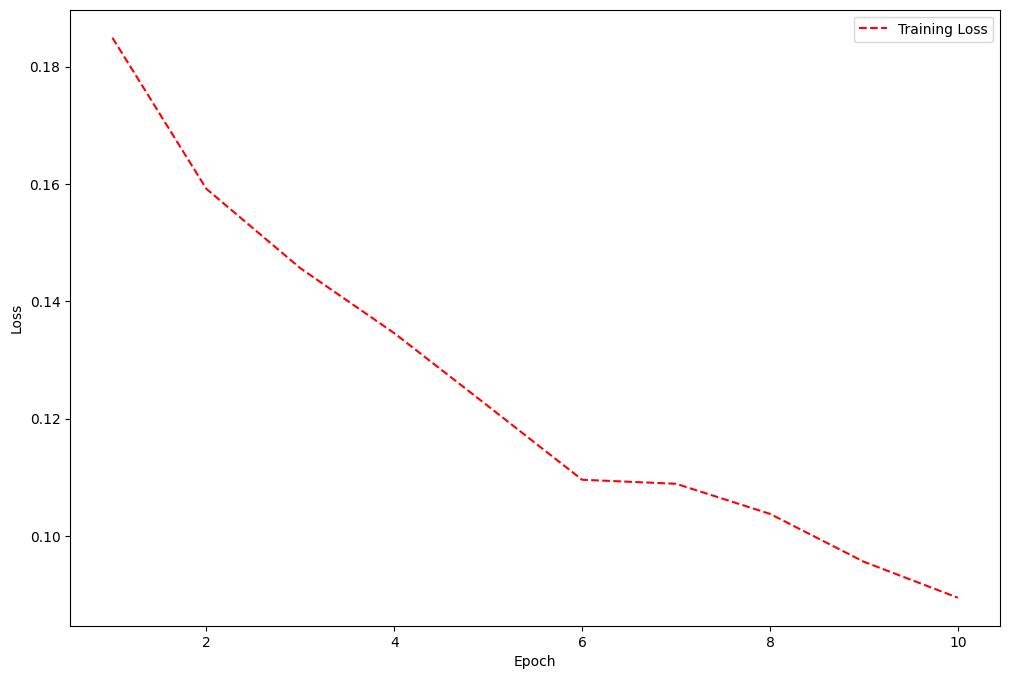

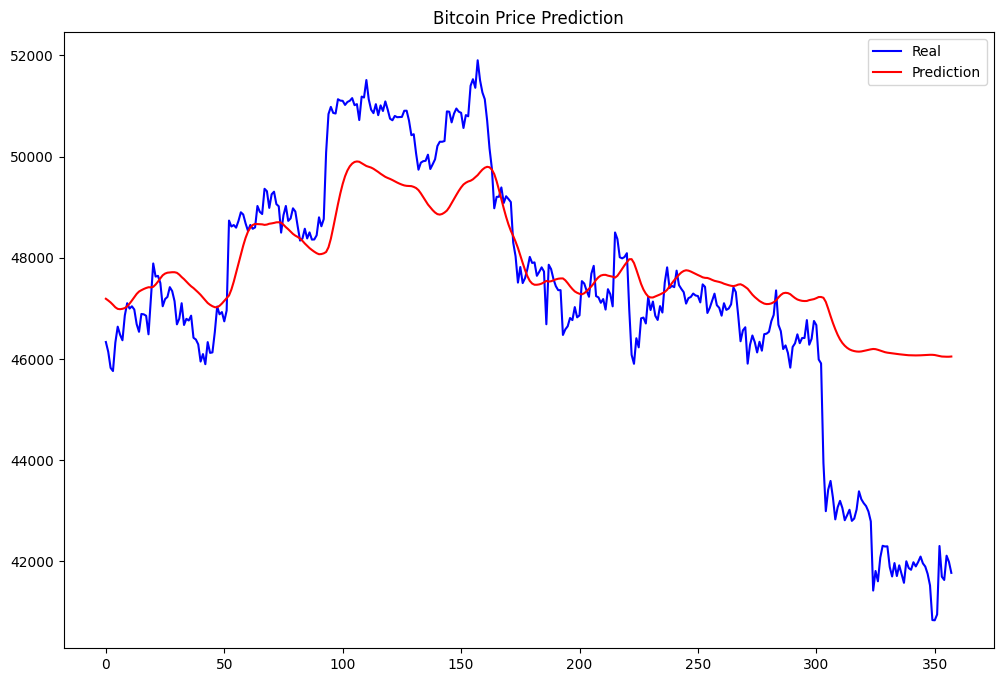

RMS=  0.7404652994722329
R2 Score=  0.5507011887855594
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 90, 32)            4352      
                                                                 
 lstm_17 (LSTM)              (None, 32)                8320      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 4s 55ms/step - loss: 0.1981
Epoch 2/10
2/2 [==============================] - 0s 71ms/step - loss: 0.1807
Epoch 3/10
2/2 [==============================] - 0s 61ms/step - loss: 0.1667
Epoch 4/10
2/2 [=========

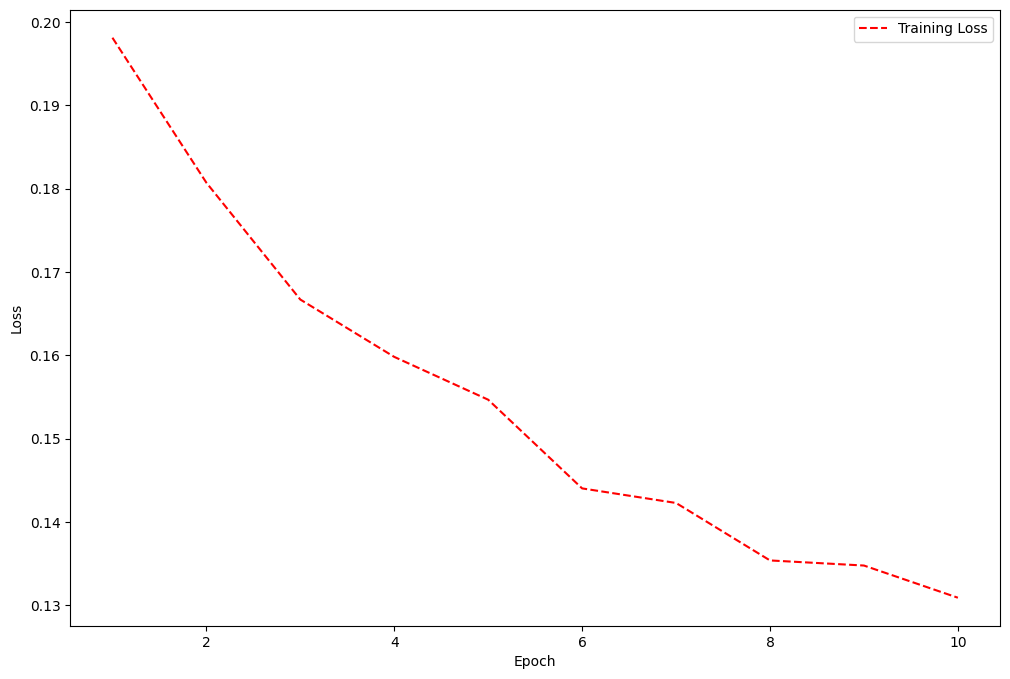

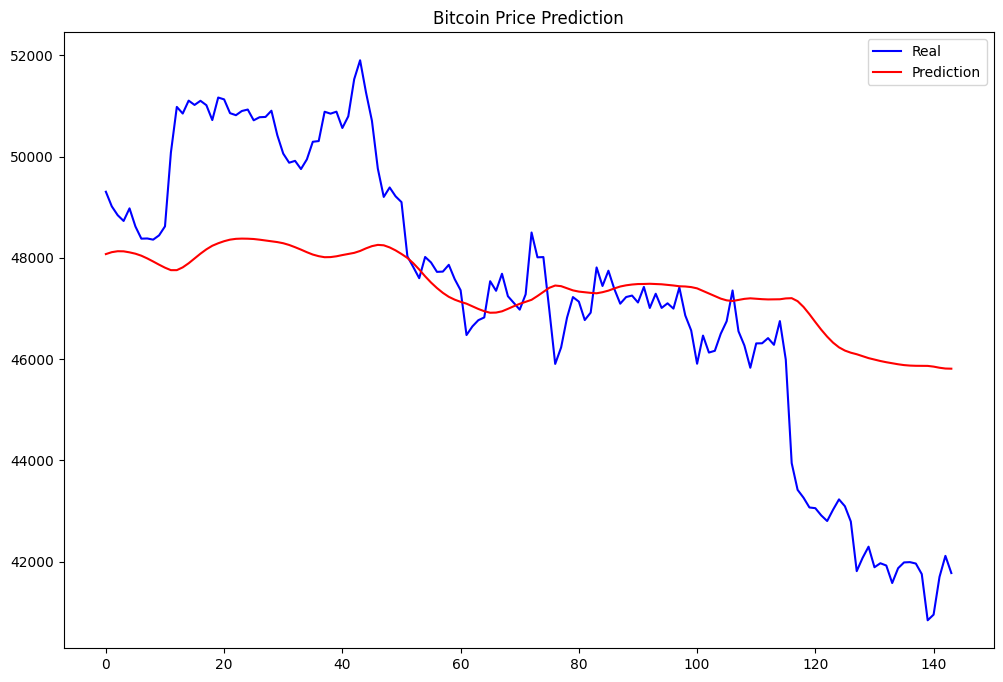

RMS=  0.9315910576171832
R2 Score=  0.41179054856849384


In [41]:
main()